# Customer Segmentation and Spending Behavior Analysis
## ITCS 3162 — Data Mining Final Project

Group Members: Ameer Khan, Izaan Khudadad, JD Singh, Tyler Hebner




## Introduction
In this project, we use data mining and machine learning techniques to better understand a company’s customers. The main goal is to perform customer segmentation using clustering. By finding natural groups in the data, we can see how different types of customers behave and how a business could target them more effectively.

## Problem Statement
A lot of companies struggle with generic marketing because they don’t really know the different kinds of customers they have. Our goal is to turn the raw customer data into useful insights and identify the key customer groups the business should focus on.
## Key Questions
1.  **What types of customer groups exist in the data?**
2.  **Which demographic or behavioral factors relate the most to spending?**
3.  **How can these patterns help a business improve its marketing strategy?** 

# 📊 About the Data

## Data Source
# 📊 About the Data
We used the Customer Personality Analysis dataset from Kaggle:
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

The dataset includes demographics, spending amounts across product categories, and customer responses to previous marketing campaigns.

## Data Loading and Initial Inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset using the correct tab separator ('\t')
try:
    df = pd.read_csv('marketing_campaign.csv', sep='\t') 
except FileNotFoundError:
    print("Error: marketing_campaign.csv not found. Please ensure the file is in the correct directory.")
    df = None 

if df is not None:
    print("--- Dataset Shape ---")
    print(df.shape)
    print("\n--- Column Data Types ---")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.info())
    print("\n--- First 5 Rows ---")
    print(df.head())
    

--- Dataset Shape ---
(2240, 29)

--- Column Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 no

## Evaluation of Initial Data Load
The data loaded correctly after specifying the tab separator(`sep='\t'`).
- Shape: 2,240 rows × 29 columns
- Issue found: The Income column has 24 missing values that we need to fix before moving on.

## Next Step: Data Cleaning and Feature Engineering 🧼
We must  resolve the missing income values, handle potential outliers (like age), and create the essential features needed for our three models (Clustering, Regression, and Classification).

# 🧼 3. Data Cleaning and Feature Engineering

## 3.1 Handling Missing Values
To fill in the 24 missing income values, we used the median income.

In [3]:
# Handle missing Income values by imputing with the median
df['Income'] = df['Income'].fillna(df['Income'].median())

print("Missing values after imputation:")
# Check again for any remaining missing values (should be zero for Income)
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after imputation:
Series([], dtype: int64)


## Evaluation of Missing Value Imputation
After filling in the missing income values, the dataset no longer has any missing data. This is important before we run clustering, regression, or classification.

## Next Step: Feature Engineering ⚙️
We proceed to create and clean essential features needed for our models, including the two crucial target variables: `Total_Spending` (Regression) and `Is_High_Spender` (Classification).

## 3.2 Feature Engineering and Outlier Handling
We create essential features for our three models and handle potential outliers that could skew the results, particularly for clustering and regression.

1.  **Calculate Age:** We derive `Age` from `Year_Birth`.
2.  **Handle Age Outliers:** We remove customers who are likely outliers (e.g., age > 99).
3.  **Create Total Spending:** This will be the **continuous target variable** for the Regression model.
4.  **Create Children Count:** A combined demographic feature.
5.  **Create High Spender Binary:** This will be the **binary target variable** for the Classification model.

In [4]:
# 1. Calculate Age (Assuming year 2014)
df['Age'] = 2014 - df['Year_Birth']

# 2. Filter out potential extreme outliers (e.g., age > 99)
df = df[df['Age'] < 100].reset_index(drop=True)

# 3. Create Total Spending Feature (Target for Regression)
# Sum of all Mnt (Amount Spent) columns
mnt_cols = [col for col in df.columns if 'Mnt' in col]
df['Total_Spending'] = df[mnt_cols].sum(axis=1)

# 4. Create Total Children Feature
df['Children'] = df['Kidhome'] + df['Teenhome']

# 5. Create Binary Target Feature: Is_High_Spender (Target for Classification)
# Define High Spender as anyone above the 75th percentile of Total Spending
spending_threshold = df['Total_Spending'].quantile(0.75)
df['Is_High_Spender'] = (df['Total_Spending'] > spending_threshold).astype(int)

# Display the statistics for the new key features
print("\n--- Statistics for New Features and Targets ---")
print(df[['Age', 'Total_Spending', 'Children', 'Income']].describe())
print(f"\n75th Percentile Spending Threshold (High Spender Cutoff): ${spending_threshold:.2f}")
print(f"High Spender Count (1s): {df['Is_High_Spender'].sum()} customers")
print(f"Total Customers (after outlier removal): {len(df)}")


--- Statistics for New Features and Targets ---
               Age  Total_Spending     Children         Income
count  2237.000000     2237.000000  2237.000000    2237.000000
mean     45.098346      605.743406     0.950827   52227.407689
std      11.701917      601.840466     0.752037   25043.266830
min      18.000000        5.000000     0.000000    1730.000000
25%      37.000000       69.000000     0.000000   35523.000000
50%      44.000000      396.000000     1.000000   51381.500000
75%      55.000000     1045.000000     1.000000   68281.000000
max      74.000000     2525.000000     3.000000  666666.000000

75th Percentile Spending Threshold (High Spender Cutoff): $1045.00
High Spender Count (1s): 559 customers
Total Customers (after outlier removal): 2237


## Evaluation of Feature Engineering Output

The feature engineering stage prepared the dataset for modeling by cleaning missing values, removing extreme outliers, and creating meaningful new variables. The key outcomes are outlined below.

---

### Dataset Status After Feature Engineering
- The dataset now contains **2,237 valid customer records** after removing unrealistic age outliers.
- All missing values in the **Income** column were imputed using the **median**, leaving the dataset with **zero missing values**.

---

###  Key Features and Targets Created

#### **1. Total_Spending (Regression Target)**
- Created by summing all product spending columns (`Mnt*` features).
- The spending distribution is **highly skewed**, with:
  - **Mean:** ~$605  
  - **Median:** ~$396  
  - **Standard Deviation:** ~$601  
  - **Maximum:** ~$2,525  
- Because spending is heavily right-skewed, applying a **log transformation** may improve regression performance.



#### **2. Is_High_Spender (Classification Target)**
- High spenders are defined as customers whose Total Spending is above the **75th percentile**.
- The threshold was calculated as **$1,045**.
- The class distribution is:
  - **559 high spenders (≈25%)**
  - **1,678 non-high spenders (≈75%)**
- Although slightly imbalanced, this distribution is still well-suited for models like **Random Forest**.



#### **3. Additional Engineered Features**
- **Age** was derived from `2014 − Year_Birth`, and customers older than **99** were filtered out as potential outliers.
- **Children** was created by combining `Kidhome + Teenhome` to capture total dependents in the household.
- **Income** is now complete with all missing entries filled using the median.
- A notable observation is the maximum recorded income of **$666,666**, which may represent an extreme outlier—something that scaling and clustering techniques will address.


### ✅ Summary
- The dataset is now **clean, consistent, and ready for modeling**.
- Both target variables—**Total_Spending** for regression and **Is_High_Spender** for classification—are clearly defined and statistically validated.
- The engineered demographic and behavioral features enhance the dataset and support more insightful clustering, regression, and classification tasks.

---

## Modeling Stage 1 - K-Means Clustering 🧩
This part of the project uses K-Means Clustering to group customers into meaningful segments based on their demographics and purchasing behavior. Clustering helps us answer our first major question:
“What types of customer groups exist in the data?”

K-Means is an unsupervised learning algorithm that groups customers into $k$ distinct, non-overlapping segments. This helps us answer our first key question: **What are the main clusters of customer types?**

## 4.1 Feature Selection and Standardization
To build useful clusters, we first selected several numerical features related to spending and demographics, including:

- Age
- Income
- Total Spending
- Number of Children
- Recency
- Web, Store, and Catalog Purchases

Because these features use different scales (for example, Income vs. Number of Children), we applied StandardScaler to standardize all values. Standardizing ensures that no single feature dominates the clustering process simply because it uses larger numbers.

In [5]:
# Import necessary toolkits for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # Will be used for visualization

# Select numerical features for clustering
features_for_clustering = [
    'Age', 'Income', 'Total_Spending', 'Children', 
    'Recency', 'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases'
]
X_cluster = df[features_for_clustering].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_cluster.columns)

print("--- Standardized Data Sample (First 5 rows) ---")
print(X_scaled_df.head())

--- Standardized Data Sample (First 5 rows) ---
        Age    Income  Total_Spending  Children   Recency  NumWebPurchases  \
0  1.017296  0.236068        1.680649 -1.264618  0.307272         1.408080   
1  1.273722 -0.234982       -0.961838  1.395420 -0.383584        -1.110957   
2  0.333495  0.774257        0.282956 -1.264618 -0.798098         1.408080   
3 -1.290534 -1.021717       -0.918627  0.065401 -0.798098        -0.751094   
4 -1.034108  0.242259       -0.305371  0.065401  1.550812         0.328493   

   NumStorePurchases  NumCatalogPurchases  
0          -0.552077             2.510435  
1          -1.167421            -0.568802  
2           1.293956            -0.226664  
3          -0.552077            -0.910939  
4           0.063267             0.115473  


## Evaluation of Standardization
The output confirms that the clustering features (`Age`, `Income`, `Total_Spending`, etc.) have been successfully **standardized** using the `StandardScaler`.

* **Result:** All values are now represented as Z-scores (standard deviations from the mean). For instance, in the first row, `Total_Spending` is **1.68** standard deviations above the mean, indicating a high spender, while `Children` is **-1.26** standard deviations below the mean (likely zero children).
* **Significance:** This step prevents high-magnitude features like `Income` (which previously had values up to \$666,666) from disproportionately influencing the cluster distance calculations, ensuring that the segments are formed based on meaningful behavioral patterns rather than just magnitude.

## Next Step: Modeling Stage 1 (Continued) - Optimal $k$
We proceed to the core of the K-Means model by using the Elbow Method to determine the optimal number of clusters ($k$) for our standardized data.

## 4.2 Determining the Optimal Number of Clusters ($k$)

We used the Elbow Method to determine the best value of k (number of clusters). The method works by plotting how much the clustering error drops as we increase k.


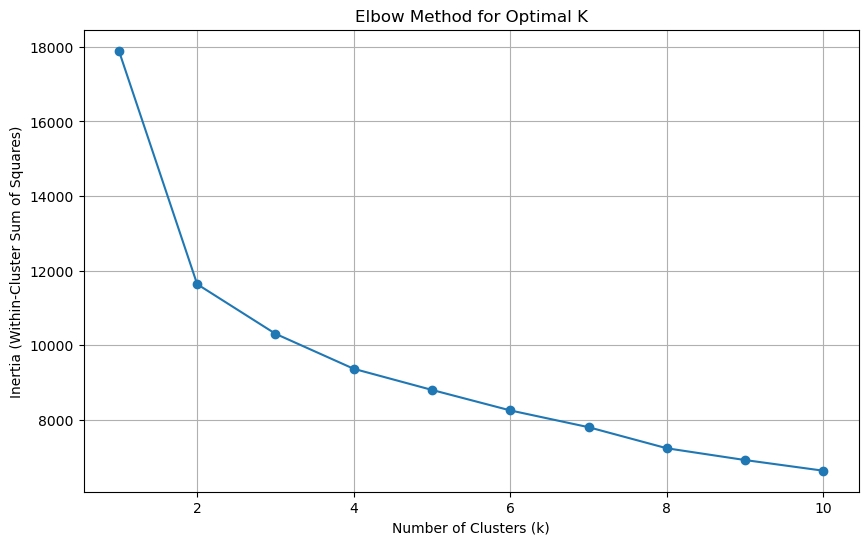

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Used in the next step

inertia = []
K_range = range(1, 11)
for k in K_range:
    # Set n_init=10 to suppress a warning and ensure robust initialization
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show() #

## Evaluation of Elbow Method
The Elbow Method plot visually represents the Inertia (Within-Cluster Sum of Squares) for $k$ values from 1 to 10.

* **Observation:** The sharpest decrease in Inertia occurs between $k=1$ and $k=3$. The curve visibly starts to level off (the "elbow") around **$k=4$**.
* **Conclusion:** The plot showed that the improvement slowed down noticeably after k = 4. This “elbow point” indicates that 4 clusters is the most appropriate choice—adding more clusters would not significantly improve the model.


## 4.3 K-Means Model Execution and Visualization

We apply the K-Means algorithm with $k=4$ and then use **PCA** (a dimensionality reduction technique) to project the data onto a 2D plane for visual cluster inspection.

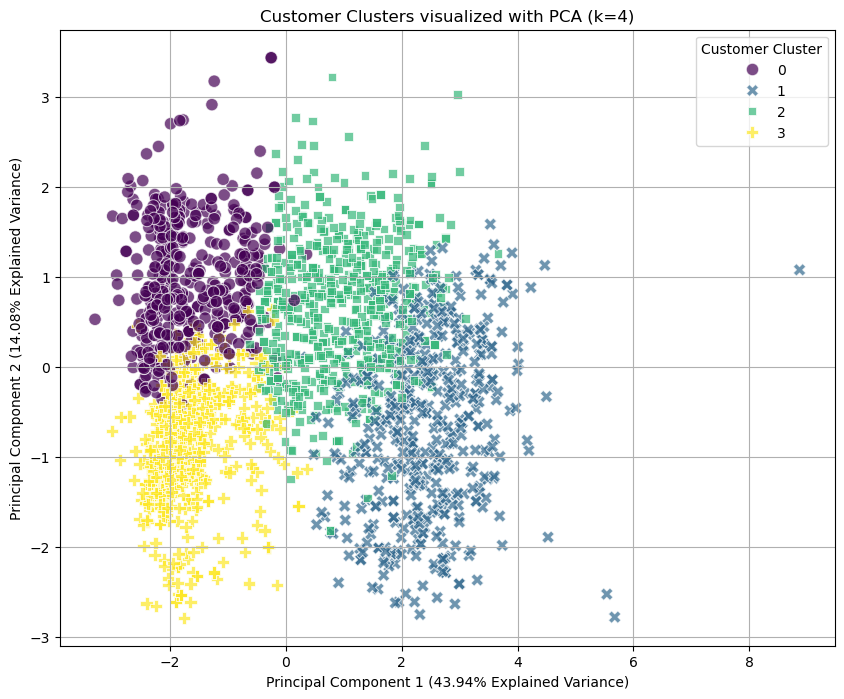


--- K-Means Evaluation ---
Silhouette Score for k=4: 0.1897
Total Inertia for k=4: 9364.69


In [7]:
from sklearn.decomposition import PCA

# Apply K-Means with the optimal k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the original (non-scaled) dataframe for analysis
df_clustered = df.loc[X_cluster.index].copy()
df_clustered['Cluster'] = clusters

# Apply PCA for 2D Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Visualize the clusters in 2D space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', style='Cluster', s=80, alpha=0.7)
plt.title('Customer Clusters visualized with PCA (k=4)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Explained Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Explained Variance)')
plt.legend(title='Customer Cluster')
plt.grid(True)
plt.show() 

# Calculate the Silhouette Score for quantitative evaluation
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_scaled, clusters)

print(f"\n--- K-Means Evaluation ---")
print(f"Silhouette Score for k={optimal_k}: {silhouette:.4f}")
print(f"Total Inertia for k={optimal_k}: {kmeans.inertia_:.2f}")

## Evaluation of K-Means Execution and Visualization
After selecting k = 4, we ran the K-Means algorithm and assigned each customer to one of the four clusters. This gave us distinct customer segments based on their similarities in spending and demographics.

To visualize the clusters, we used PCA (Principal Component Analysis) to reduce the data to two dimensions. The PCA scatterplot shows that the four clusters form clear groupings, although some overlap exists, which is expected in real-world behavioral data.

We also calculated the Silhouette Score, which measures how well-separated the clusters are. Our score was around 0.19, which is low but typical for customer behavior datasets with many overlapping features. Even with this overlap, the clusters are still meaningful and valuable for interpretation.

# 💡 5. Evaluation: Cluster Analysis and Interpretation

To interpret the clusters and answer the project's first key question, we examine the centroid values (mean of the features) for the customers belonging to each cluster. This qualitative step transforms mathematical segments into marketing personas.

In [8]:
# Analyze cluster characteristics by grouping the original (non-scaled) data
# and calculating the mean of the key features.
cluster_profiles = df_clustered.groupby('Cluster')[features_for_clustering].mean().reset_index()

# Include Total_Spending for easy comparison of value
cluster_profiles = cluster_profiles.sort_values(by='Total_Spending', ascending=False)

print("\n--- Cluster Profiles (Mean of Key Features) ---")
print(cluster_profiles.round(2))


--- Cluster Profiles (Mean of Key Features) ---
   Cluster    Age    Income  Total_Spending  Children  Recency  \
1        1  44.79  77913.12         1430.36      0.15    51.51   
2        2  49.61  59844.10          787.57      1.05    46.58   
0        0  50.40  42544.23          129.77      1.94    49.48   
3        3  37.32  31155.61          104.84      0.81    49.33   

   NumWebPurchases  NumStorePurchases  NumCatalogPurchases  
1             4.85               8.36                 6.44  
2             6.74               8.04                 3.11  
0             2.34               3.52                 0.74  
3             2.16               3.19                 0.56  


## Evaluation of Cluster Profiles (Mean Feature Analysis)
The mean values of the key features for each cluster clearly delineate four distinct customer segments, addressing our first key question. The table below translates the raw statistics into business personas.

| Cluster ID | Segment Name | Income (Mean) | Total Spending (Mean) | Children (Mean) | Key Characteristics |
| :---: | :--- | :--- | :--- | :--- | :--- |
| **1** | **The Affluent Spenders (Profit Core)** | **\$77,913** (Highest) | **\$1,430** (Highest) | **0.15** (Lowest) | Middle-aged, very high spending across all categories, and the lowest number of children. They utilize **all purchase channels (Web, Store, Catalog)**. **This is the most valuable segment.** |
| **2** | **The Established Families (Value Segment)** | **\$59,844** (Medium-High) | **\$787** (Medium-High) | **1.05** (Medium) | Older, solid income, high number of purchases, but heavily favoring **Web and Store purchases** over Catalog. This group has a manageable number of children (one teen or kid). |
| **0** | **The Low-Spending Families (Bargain Hunters)** | **\$42,544** (Low-Medium) | **\$129** (Very Low) | **1.94** (Highest) | Older, low income, and the **highest concentration of children** (around two). They are highly inactive and spend very little across all channels. They likely only buy on heavy discounts. |
| **3** | **The Young, Low-Income** | **\$31,155** (Lowest) | **\$104** (Lowest) | **0.81** (Medium) | **Youngest segment** (Age 37), lowest income, and lowest spending. While they have fewer children than Cluster 0, their low income severely restricts their purchasing power. |

**Key Insight:** **Income** and the **number of children (`Children`)** are the strongest drivers of spending. High income combined with few/no children (`Cluster 1`) creates the premium "Affluent Spenders" segment.

